In [16]:
import json
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

def process_transactions(data):
    """Process raw transaction data into features with enhanced feature engineering"""
    df = pd.DataFrame(data)

    # Extract nested data
    df['assetSymbol'] = df['actionData'].apply(lambda x: x['assetSymbol'])
    df['amount'] = df['actionData'].apply(lambda x: float(x['amount']))
    df['assetPriceUSD'] = df['actionData'].apply(lambda x: float(x['assetPriceUSD']))

    # Calculate USD value
    df['amount_usd'] = df['amount'] * df['assetPriceUSD']

    # Convert timestamps
    df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s')
    df['date'] = df['timestamp'].dt.date

    # Enhanced feature engineering
    features = []
    for wallet, group in df.groupby('userWallet'):
        # Basic stats
        total_tx = len(group)
        unique_assets = group['assetSymbol'].nunique()
        amount_stats = group['amount_usd'].agg(['mean', 'std', 'sum', 'max', 'min'])

        # Time-based features
        time_diff = (group['timestamp'].max() - group['timestamp'].min()).days
        tx_frequency = time_diff / total_tx if total_tx > 1 and time_diff > 0 else 0
        recency = (datetime.now() - group['timestamp'].max()).days

        # Action ratios
        action_counts = group['action'].value_counts(normalize=True)

        # Asset type ratios
        asset_types = group['assetSymbol'].apply(
            lambda x: 'stablecoin' if x in ['USDC', 'USDT', 'DAI']
            else 'crypto' if x in ['WETH', 'WBTC']
            else 'native' if x in ['WMATIC', 'WPOL']
            else 'other'
        )
        asset_ratios = asset_types.value_counts(normalize=True)

        # Volatility measure
        daily_volume = group.groupby(group['timestamp'].dt.date)['amount_usd'].sum()
        volume_volatility = daily_volume.std() / daily_volume.mean() if len(daily_volume) > 1 else 0

        wallet_features = {
            'wallet': wallet,
            'total_tx': total_tx,
            'unique_assets': unique_assets,
            'avg_tx_amount': amount_stats['mean'],
            'std_tx_amount': amount_stats['std'] if not np.isnan(amount_stats['std']) else 0,
            'total_volume': amount_stats['sum'],
            'max_tx': amount_stats['max'],
            'tx_frequency': tx_frequency,
            'days_active': time_diff if total_tx > 1 else 0,
            'recency': recency,
            'deposit_ratio': action_counts.get('deposit', 0),
            'borrow_ratio': action_counts.get('borrow', 0),
            'repay_ratio': action_counts.get('repay', 0),
            'redeem_ratio': action_counts.get('redeemunderlying', 0),
            'stablecoin_ratio': asset_ratios.get('stablecoin', 0),
            'crypto_ratio': asset_ratios.get('crypto', 0),
            'native_ratio': asset_ratios.get('native', 0),
            'volume_volatility': volume_volatility,
            'active_days_ratio': time_diff / (recency + time_diff) if (recency + time_diff) > 0 else 0
        }
        features.append(wallet_features)

    return pd.DataFrame(features)

def train_model(features):
    """Train a more robust scoring model with proper validation"""
    # Split data (in practice, we'd use labeled historical data)
    X = features.drop('wallet', axis=1)

    # Synthetic target variable - in practice would use real labels
    # This creates a more realistic synthetic score based on features
    y = (
        300 +
        100 * np.log1p(X['total_volume']) +
        50 * X['unique_assets'] +
        30 * (1 - X['recency']/365) +
        20 * X['stablecoin_ratio'] -
        10 * X['volume_volatility'] +
        np.random.normal(0, 20, len(X))
    )
    y = np.clip(y, 300, 850)  # Keep scores in reasonable range

    # Define preprocessing
    numeric_features = X.select_dtypes(include=['float64', 'int64']).columns
    numeric_transformer = Pipeline(steps=[
        ('scaler', StandardScaler())
    ])

    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_features)
        ])

    # Create pipeline with better model
    model = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('regressor', RandomForestRegressor(
            n_estimators=200,
            max_depth=10,
            min_samples_split=5,
            random_state=42,
            n_jobs=-1
        ))
    ])

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    # Train model
    model.fit(X_train, y_train)

    # Evaluate
    preds = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, preds))
    print(f"Model trained with RMSE: {rmse:.2f}")

    return model

def generate_scores(data_path):
    """Generate wallet scores from transaction data with enhanced processing"""
    with open(data_path) as f:
        data = json.load(f)

    # Process transactions
    features = process_transactions(data)

    # Train model (in production would load pre-trained)
    model = train_model(features)

    # Predict scores
    X = features.drop('wallet', axis=1)
    scores = model.predict(X)

    # Scale to 300-850 range (common credit score range)
    scores = np.clip(scores, 300, 850)
    scores = np.round(scores).astype(int)

    # Combine with wallet addresses
    results = pd.DataFrame({
        'wallet': features['wallet'],
        'score': scores,
        'total_volume': features['total_volume'],
        'days_active': features['days_active'],
        'unique_assets': features['unique_assets']
    })

    return results.sort_values('score', ascending=False)

# Generate and display scores
scores = generate_scores('user-wallet-transactions.json')
print("\nTop 10 Wallets by Score:")
print(scores.head(10))
print("\nScore Distribution:")
print(scores['score'].describe())

Model trained with RMSE: 6.27

Top 10 Wallets by Score:
                                          wallet  score  total_volume  \
3496  0x06192f889f17bf2aff238d08d8c26cbcfcc7b45a    850  9.179847e+23   
0     0x00000000001accfa9cef68cf5371a23025b6d4b6    850  1.987664e+09   
1     0x000000000051d07a4fb3bd10121a343d85818da6    850  2.856945e+20   
2     0x000000000096026fb41fc39f9875d164bd82e2dc    850  5.152311e+15   
3     0x0000000000e189dd664b9ab08a33c4839953852c    850  9.803600e+20   
4     0x0000000002032370b971dabd36d72f3e5a7bf1ee    850  3.797495e+23   
5     0x000000000a38444e0a6e37d3b630d7e855a7cb13    850  2.300808e+22   
6     0x000000003853fcedcd0355fec98ca3192833f00b    850  7.637632e+16   
7     0x000000003ce0cf2c037493b1dc087204bd7f713e    850  8.908807e+23   
3480  0x061122cffab0f594d3689865e935b2961f0a309a    850  2.096558e+23   

      days_active  unique_assets  
3496           59              7  
0               0              1  
1               0              1  


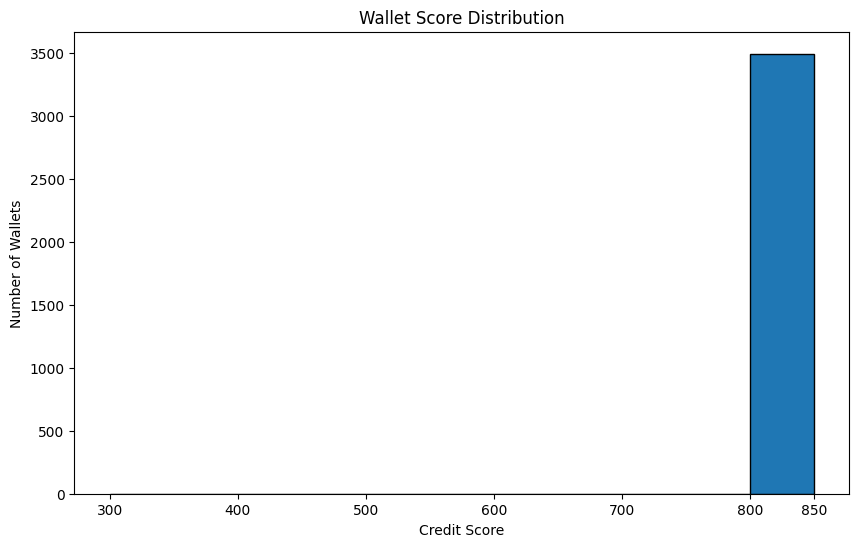

In [17]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
bins = [300, 400, 500, 600, 700, 800, 850]
scores['score'].plot.hist(bins=bins, edgecolor='black')
plt.title('Wallet Score Distribution')
plt.xlabel('Credit Score')
plt.ylabel('Number of Wallets')
plt.xticks(bins)
plt.show()
